## Exercise-01

In [1]:
#import corpus
import nltk
from nltk.corpus import treebank
from nltk.corpus import brown
from nltk.corpus import cess_esp as spanish

#import classifier stuff
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#import some necessary stuff
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define feature extractor and other necessary functions

# Feature Extractor
def features(sentence, index):
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'prefix-1': sentence[index][0],
        'suffix-1': sentence[index][-1],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1]
    }

# Un-tag Sentences
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

# Apply
def transform_to_dataset(tagged_sentences):
    W, X, y = [], [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            W.append(untag(tagged)[index])
            X.append(features(untag(tagged), index))
            y.append(tagged[index][1])
 
    return W, X, y


def classifier(name):
    if name == 'logistic':
        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression()       
    elif name == 'decision-tree':
        from sklearn.tree import DecisionTreeClassifier
        classifier = DecisionTreeClassifier()       
    elif name =='MLP':
        from sklearn.neural_network import MLPClassifier
        MLPClassifier(alpha=1)
    elif name == 'GaussianNB':
        from sklearn.naive_bayes import GaussianNB
        classifier = GaussianNB()     
    else:
        raise NotImplementedError('Classifier not implemented.')    
    
    clf = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', classifier)
    ])
    return clf
    

In [3]:
# Load Dataset

# Treebank
treebank_tag = treebank.tagged_sents()

# Brown
brown_tag = brown.tagged_sents()

# Split Dataset
test_fraction = 0.2
treebank_train, treebank_test = train_test_split(treebank_tag, test_size=test_fraction)
brown_train, brown_test = train_test_split(brown_tag, test_size=test_fraction)

In [4]:
# Prepare Dataset

W_treebank_train, X_treebank_train, Y_treebank_train = transform_to_dataset(treebank_train)
W_treebank_test, X_treebank_test, Y_treebank_test = transform_to_dataset(treebank_test)

W_brown_train, X_brown_train, Y_brown_train = transform_to_dataset(brown_train)
W_brown_test, X_brown_test, Y_brown_test = transform_to_dataset(brown_test)

In [5]:
def train_test_classifier(X_train, Y_train, X_test, Y_test, clf_name):
  
    clf_name = 'logistic'
    clf = classifier(clf_name)
    try:
        clf.fit(X_train, Y_train)
    except MemoryError:
        print('Cannot fit a model! MemoryError. Dataset too big will train on 50 percent of sample set')
        try:
            X_train = X_train[:int(0.5*len(X_train))]
            Y_train = Y_train[:int(0.5*len(Y_train))]
            clf.fit(X_train, Y_train)
        except MemoryError:
            print('Cannot fit a model! MemoryError. Dataset too big will train on 25 percent of sample set')
            try:
                X_train = X_train[:int(0.25*len(X_train))]
                Y_train = Y_train[:int(0.25*len(Y_train))]
                clf.fit(X_train, Y_train)
            except MemoryError:
                print('Cannot fit a model! MemoryError. Dataset too big will train on 10 percent of sample set')
                try:
                    X_train = X_train[:int(0.10*len(X_train))]
                    Y_train = Y_train[:int(0.10*len(Y_train))]
                    clf.fit(X_train, Y_train)                
                except MemoryError:
                    print('Cannot fit a model! MemoryError. Dataset too big select smaller sample set')
    return clf.score(X_test, Y_test)


In [6]:
def pos_tagging_pretrained_model(W_test, Y_test, pretrained_file):
    
    try:
        pretrained_tagger = nltk.data.load(pretrained_file)
        tag_test_data = pretrained_tagger.tag(W_test)
    except LookupError:
        print('Pretrained Model Not exist in NLTK. Using pretrained model based on perceptron')
        tag_test_data = nltk.pos_tag(W_test)
    
    correct_prediction = 0
    for pretrained_tag, true_tag in zip(tag_test_data, Y_test):
        if pretrained_tag[1] == true_tag:
            correct_prediction += 1
    return correct_prediction/float(len(tag_test_data))
    # Evaluate pre-trained Model on test data


In [7]:
def rule_based_classifier(X_train, X_test):
    
    patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'), (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'), (r'.*\'s$', 'NN$'),               
             (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]
    # Train Different Tagger
    def_model = nltk.DefaultTagger('NN')
    uni_model = nltk.UnigramTagger(X_train)
    bi_model = nltk.BigramTagger(X_train)
    tri_model = nltk.TrigramTagger(X_train)
    regexp_model = nltk.RegexpTagger(patterns)
    
    accuracy_def_test = def_model.evaluate(X_test)
    accuracy_uni_test = uni_model.evaluate(X_test)
    accuracy_bi_test = bi_model.evaluate(X_test)
    accuracy_tri_test = tri_model.evaluate(X_test)
    accuracy_regexp_test = regexp_model.evaluate(X_test)
    
    # performance of Default Tagger
    print('Default Tagger Accuracy on Training Set {0:.2f}'.format(def_model.evaluate(X_train)))
    print('Default Tagger Accuracy on Test Set {0:.2f}'.format(accuracy_def_test))
    print()
    # performance of Unigram Tagger
    print('Unigram Tagger Accuracy on Training Set {0:.2f}'.format(uni_model.evaluate(X_train)))
    print('Unigram Tagger Accuracy on Test Set {0:.2f}'.format(accuracy_uni_test))
    print()
    # performance of Bigram Tagger
    print('Bigram Tagger Accuracy on Training Set {0:.2f}'.format(bi_model.evaluate(X_train)))
    print('Bigram Tagger Accuracy on Test Set {0:.2f}'.format(accuracy_bi_test))
    print()
    # performance of Trigram Tagger
    print('Trigram Tagger Accuracy on Training Set {0:.2f}'.format(tri_model.evaluate(treebank_train)))
    print('Trigram Tagger Accuracy on Test Set {0:.2f}'.format(accuracy_tri_test))
    print()
    # performance of Regex Tagger
    print('Regex Tagger Accuracy on Training Set {0:.2f}'.format(regexp_model.evaluate(X_train)))
    print('Regex Tagger Accuracy on Test Set {0:.2f}'.format(accuracy_regexp_test))
    print()
    
    return [accuracy_def_test, accuracy_uni_test, accuracy_bi_test, accuracy_tri_test, accuracy_regexp_test]

## Task-1

a) POS tagger Model for TreeBank Dataset

In [8]:
clf_name = 'logistic'
accuracy_treebank = train_test_classifier(X_treebank_train, Y_treebank_train, X_treebank_test, Y_treebank_test, clf_name)
print('Accuracy on Test Set for TreeBank {0:.2f} '.format(accuracy_treebank))

Accuracy on Test Set for TreeBank 0.95 


b) Pre-trained Model Using NLTK Max-Entropy for TreeBank Dataset

In [9]:
pretrained_file = 'taggers/maxent_treebank_pos_tagger/english.pickle'

accuracy_treebank_pretrained = pos_tagging_pretrained_model(W_treebank_test, Y_treebank_test, pretrained_file)
print('Accuracy on Test Set for TreeBank using pretrained model {0:.2f} '.format(accuracy_treebank_pretrained))

Accuracy on Test Set for TreeBank using pretrained model 0.99 


(c) Rule Based Classifier for TreeBank Dataset


In [10]:
print('Evaluation On TreeBank')
accuracy_def_test_tb, accuracy_uni_test_tb, accuracy_bi_test_tb, accuracy_tri_test_tb, accuracy_regexp_test_tb = rule_based_classifier(treebank_train, treebank_test)
print()

Evaluation On TreeBank
Default Tagger Accuracy on Training Set 0.13
Default Tagger Accuracy on Test Set 0.14

Unigram Tagger Accuracy on Training Set 0.96
Unigram Tagger Accuracy on Test Set 0.88

Bigram Tagger Accuracy on Training Set 0.91
Bigram Tagger Accuracy on Test Set 0.16

Trigram Tagger Accuracy on Training Set 0.91
Trigram Tagger Accuracy on Test Set 0.09

Regex Tagger Accuracy on Training Set 0.22
Regex Tagger Accuracy on Test Set 0.22




(d)  POS tagger Model for Brown Dataset

In [11]:
accuracy_brown = train_test_classifier(X_brown_train, Y_brown_train, X_brown_test, Y_brown_test, 'logistic')
print('Accuracy on Test Set for Brown Corpus {0:.2f} '.format(accuracy_brown))

Cannot fit a model! MemoryError. Dataset too big will train on 50 percent of sample set
Cannot fit a model! MemoryError. Dataset too big will train on 25 percent of sample set
Cannot fit a model! MemoryError. Dataset too big will train on 10 percent of sample set
Accuracy on Test Set for Brown Corpus 0.83 


(e) Pre-trained Model Using NLTK Max-Entropy for TreeBank Dataset

In [12]:
pretrained_file = 'taggers/maxent_brown_pos_tagger/english.pickle'

accuracy_brown_pretrained = pos_tagging_pretrained_model(W_brown_test, Y_brown_test, pretrained_file)
print('Accuracy on Test Set for Brown Corpus using pretrained model {0:.2f} '.format(accuracy_brown_pretrained))

Pretrained Model Not exist in NLTK. Using pretrained model based on perceptron
Accuracy on Test Set for Brown Corpus using pretrained model 0.62 


(f) Rule Based Classifier for Brown Dataset

In [13]:
print('Evaluation On Brown')
accuracy_def_test_brown, accuracy_uni_test_brown, accuracy_bi_test_brown, accuracy_tri_test_brown, accuracy_regexp_test_brown = rule_based_classifier(brown_train, brown_test)
print()

Evaluation On Brown
Default Tagger Accuracy on Training Set 0.13
Default Tagger Accuracy on Test Set 0.13

Unigram Tagger Accuracy on Training Set 0.93
Unigram Tagger Accuracy on Test Set 0.90

Bigram Tagger Accuracy on Training Set 0.82
Bigram Tagger Accuracy on Test Set 0.32

Trigram Tagger Accuracy on Training Set 0.04
Trigram Tagger Accuracy on Test Set 0.16

Regex Tagger Accuracy on Training Set 0.20
Regex Tagger Accuracy on Test Set 0.19




Plot of Classifier vs Accuracy for Task-1

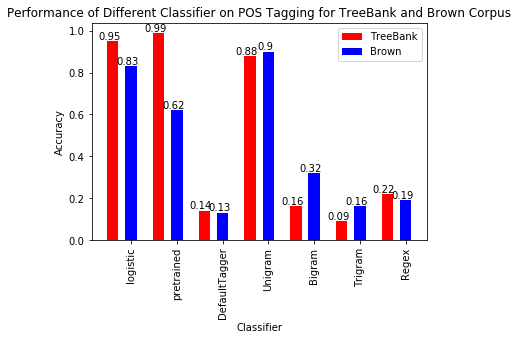

In [14]:
treebank_results = [accuracy_treebank, accuracy_treebank_pretrained, accuracy_def_test_tb, accuracy_uni_test_tb, accuracy_bi_test_tb, accuracy_tri_test_tb, accuracy_regexp_test_tb]
brown_results = [accuracy_brown, accuracy_brown_pretrained, accuracy_def_test_brown, accuracy_uni_test_brown, accuracy_bi_test_brown, accuracy_tri_test_brown, accuracy_regexp_test_brown]

x_axis = np.arange(len(treebank_results))
treebank_results = [round(i, 2) for i in treebank_results]
bar1 = plt.bar(x_axis-0.40, treebank_results, color = 'r', width=0.25, align='center')
[plt.text(bar.get_x() + bar.get_width()/5., bar.get_height(), bar.get_height(), ha='center', va='bottom') for bar in bar1]

brown_results = [round(i, 2) for i in brown_results]
bar2 = plt.bar(x_axis, brown_results, color = 'b', width=0.25, align='center')
[plt.text(bar.get_x() + bar.get_width()/5., bar.get_height(), bar.get_height(), ha='center', va='bottom') for bar in bar2]

plt.title('Performance of Different Classifier on POS Tagging for TreeBank and Brown Corpus')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

plt.xticks(x_axis, (clf_name,'pretrained','DefaultTagger','Unigram','Bigram','Trigram','Regex'), rotation='vertical')
plt.legend((bar1[0], bar2[0]), ('TreeBank', 'Brown'))
plt.show()

## Task 2

(a) POS Tagger Model for Spanish Corpus

In [15]:
# Load Dataset
spanish_tag = spanish.tagged_sents()

# Split Dataset
test_fraction = 0.2
spanish_train, spanish_test = train_test_split(spanish_tag, test_size=test_fraction)

def features(sentence, index):
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0] if sentence[index] != '' else False,
        'prefix-1': sentence[index][0] if sentence[index] != '' else '',
        'suffix-1': sentence[index][-1] if sentence[index] != '' else '',
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1]
    }

# Create Features
W_spanish_train, X_spanish_train, Y_spanish_train = transform_to_dataset(spanish_train)
W_spanish_test, X_spanish_test, Y_spanish_test = transform_to_dataset(spanish_test)

In [16]:
clf_name = 'logistic'
accuracy_spanish = train_test_classifier(X_spanish_train, Y_spanish_train, X_spanish_test, Y_spanish_test, clf_name)
print('Accuracy on Test Set for Spanish Corpus {0:.2f} '.format(accuracy_spanish))

Cannot fit a model! MemoryError. Dataset too big will train on 50 percent of sample set
Accuracy on Test Set for Spanish Corpus 0.89 


(b) POS Pre-trained Model for Spanish Corpus

In [17]:
import os
os.environ['TREETAGGER_HOME'] = "/home/asif/MA-INF-4222-NLP-Lab/2018_SoSe/cmd"

from treetagger import TreeTagger

treetagger_spanish = TreeTagger(language='spanish')
tag_test_data = treetagger_spanish.tag(W_spanish_test)
correct_prediction = 0
for pretrained_tag, true_tag in zip(tag_test_data, Y_spanish_test):
    if pretrained_tag[1] == true_tag:
        correct_prediction += 1
accuracy_spanish_pretrained = correct_prediction/float(len(tag_test_data))
print('Accuracy on Test Set for Spanish Corpus using pretrained model {} '.format(accuracy_spanish_pretrained))

Accuracy on Test Set for Spanish Corpus using pretrained model 0.0 


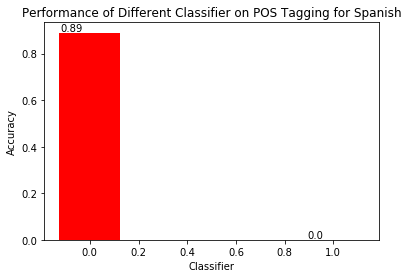

In [18]:
spanish_results = [accuracy_spanish, accuracy_spanish_pretrained]
spanish_results = [round(i, 2) for i in spanish_results]

x_axis = np.arange(len(spanish_results))
bar = plt.bar(x_axis, spanish_results, color = 'r', width=0.25, align='center')
[plt.text(bar.get_x() + bar.get_width()/5., bar.get_height(), bar.get_height(), ha='center', va='bottom') for bar in bar]

plt.title('Performance of Different Classifier on POS Tagging for Spanish')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()